### Import required libraries

In [1]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.tree
import sklearn.metrics

from matplotlib import pyplot as plt
import seaborn as sns

### 1.1: Compute true/false positives/negatives.

In [2]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    
    for i in range(len(yhat_N)):
        if ytrue_N[i]==yhat_N[i]==1:
            TP +=1
        if ytrue_N[i]==yhat_N[i]==0:
            TN += 1
        if yhat_N[i]==1 and ytrue_N[i]==0:
            FP +=1
        if yhat_N[i]==0 and ytrue_N[i]==1:
            FN +=1
   
    return TP, TN, FP, FN

### Supplied functions for later use


In [3]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)
    
    
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [4]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: hist of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### 1.2: Load the dataset.

In [5]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_cancer/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [6]:
y_tr_M = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_cancer/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 1.3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.

compute and print the accuracy of the always-0 classifier on validation and test outputs.

In [7]:
yhat_N=np.zeros(180,)
TP1,TN1,FP, FN=calc_TP_TN_FP_FN(y_va_N, yhat_N)
acc1 = (TP1+TN1)/len(y_va_N)
TP2,TN2,FP, FN=calc_TP_TN_FP_FN(y_te_N, yhat_N)
acc2 = (TP2+TN2)/len(y_te_N)

print("Always-0: accuracy on VALID: %.3f" % acc1) 
print("Always-0: accuracy on TEST : %.3f" % acc2)

Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861


#### (b) Print a confusion matrix for the always-0 classifier.

generate a confusion matrix for the always-0 classifier on the validation set.

In [8]:
yproba1_N=np.zeros(180,)
print(calc_confusion_matrix_for_threshold(y_va_N, yproba1_N, thresh=1.0))

Predicted    0  1
True             
0          155  0
1           25  0


The accuracy of the alwasy-0 classifier seems decent. However, I wouldn't use this classifier in this problem, because we should care about picking out those people who actual have cancer.

### 1.4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

In [9]:
tr_loss_list = list()
va_loss_list = list()

C_grid = np.logspace(-9, 6, 31)

for C in C_grid:
    
    logreg = sklearn.linear_model.LogisticRegression(penalty='l2', C=C, solver='liblinear',random_state = 0)     
    logreg.fit(x_tr_M2, y_tr_M) # fit model
    # make class predictions for the testing set
    y_pred_proba = logreg.predict_proba(x_tr_M2)[:,1] # convention
    loss = sklearn.metrics.log_loss(y_tr_M, y_pred_proba)
    tr_loss_list.append(loss)
    
    y_pred_proba2 = logreg.predict_proba(x_va_N2)[:,1] # convention
    loss2 = sklearn.metrics.log_loss(y_va_N, y_pred_proba2)
    va_loss_list.append(loss2)



best_va = np.argmin(va_loss_list)
best_va_c = C_grid[best_va]
print(best_va_c)
bestmodel_va = sklearn.linear_model.LogisticRegression(penalty='l2', C=best_va_c, solver='liblinear',random_state = 0) 
bestmodel_va 

31.622776601683793


LogisticRegression(C=31.622776601683793, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

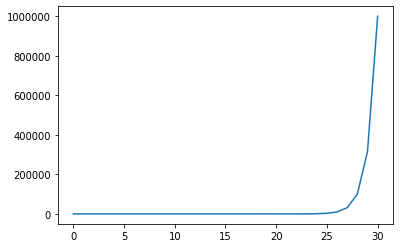

In [10]:
C_grid
plt.plot(C_grid)

#### Plot logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

Best C-value for LR with 2-feature data: 31.623
Validation set log-loss at best C-value: 0.3549


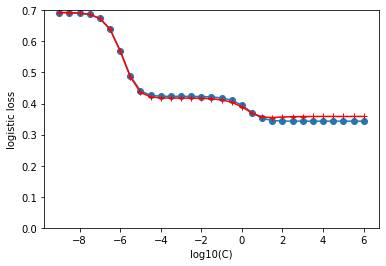

In [11]:
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);

plt.plot(np.log10(C_grid),tr_loss_list,marker='o')
plt.plot(np.log10(C_grid),va_loss_list,c="red",marker='+')

min_logloss = sorted(va_loss_list)[0]

print("Best C-value for LR with 2-feature data: %.3f" % best_va_c)
print("Validation set log-loss at best C-value: %.4f" % min_logloss)

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

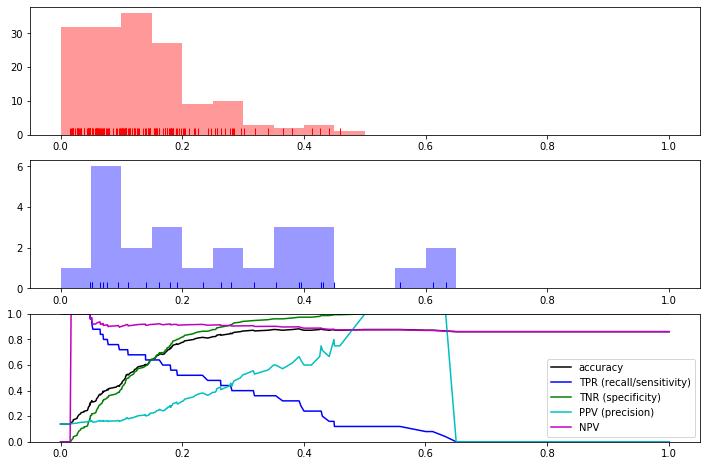

In [12]:
bestmodel_va.fit(x_tr_M2, y_tr_M) 
y_pred = bestmodel_va.predict_proba(x_va_N2)[:,1]

make_plot_perf_vs_threshold(y_va_N, y_pred, bin_edges=np.linspace(0, 1, 21))

#### (c) Model fitting with 3-feature data

In [13]:
tr_loss_list3 = list()
va_loss_list3 = list()

C_grid = np.logspace(-9, 6, 31)

# Build and evaluate model for each value C
for C in C_grid:
    
    logreg = sklearn.linear_model.LogisticRegression(penalty='l2', C=C, solver='liblinear',random_state = 0)     
    logreg.fit(x_tr_M3, y_tr_M) # fit model
    y_pred_proba = logreg.predict_proba(x_tr_M3)[:,1] # convention
    loss = sklearn.metrics.log_loss(y_tr_M, y_pred_proba)
    tr_loss_list3.append(loss)
    
    # make class predictions for the testing set
    y_pred_proba2 = logreg.predict_proba(x_va_N3)[:,1] # convention
    loss2 = sklearn.metrics.log_loss(y_va_N, y_pred_proba2)
    va_loss_list3.append(loss2)


# bestmodel_tr = sklearn.linear_model.LogisticRegression(penalty='l2', C=best_tr_c, solver='liblinear',random_state = 0) 

best_va3 = np.argmin(va_loss_list3)
best_va_c3 = C_grid[best_va3]
bestmodel_va3 = sklearn.linear_model.LogisticRegression(penalty='l2', C=best_va_c3, solver='liblinear',random_state = 0) 
bestmodel_va3

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

#### Plot logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.


Best C-value for LR with 3-feature data: 30.000
Validation set log-loss at best C-value: 0.3549


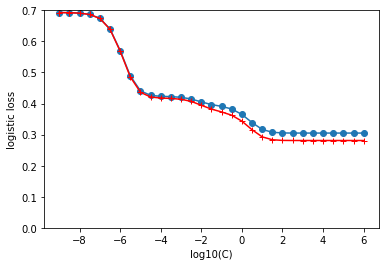

In [14]:
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);

plt.plot(np.log10(C_grid),tr_loss_list3,marker='o')
plt.plot(np.log10(C_grid),va_loss_list3,c="red",marker='+')

min_logloss = sorted(va_loss_list)[0]

print("Best C-value for LR with 3-feature data: %.3f" % best_va3) 
print("Validation set log-loss at best C-value: %.4f" % min_logloss)

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

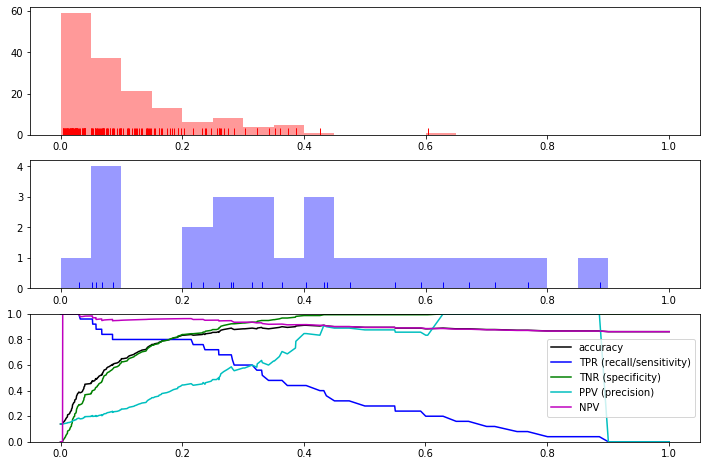

In [15]:

bestmodel_va3.fit(x_tr_M3, y_tr_M) 
y_pred = bestmodel_va3.predict_proba(x_va_N3)[:,1]
make_plot_perf_vs_threshold(y_va_N, y_pred, bin_edges=np.linspace(0, 1, 21))

### 1.5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.


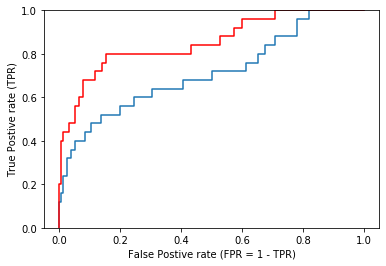

In [16]:

fpr1, tpr1, thresholds1 =sklearn.metrics.roc_curve(y_va_N, bestmodel_va.predict_proba(x_va_N2)[:,1])
fpr2, tpr2, thresholds2 =sklearn.metrics.roc_curve(y_va_N, bestmodel_va3.predict_proba(x_va_N3)[:,1])
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2,c="red")

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");

#### (b) Plot ROC curves on the test set.

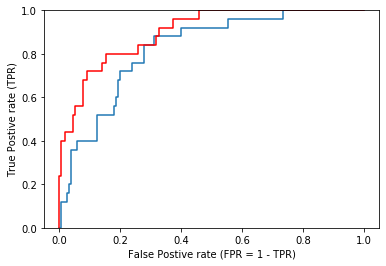

In [17]:
fpr1, tpr1, thresholds1 =sklearn.metrics.roc_curve(y_te_N, bestmodel_va.predict_proba(x_te_N2)[:,1])
fpr2, tpr2, thresholds2 =sklearn.metrics.roc_curve(y_te_N, bestmodel_va3.predict_proba(x_te_N3)[:,1])
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2,c="red")


plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");

A perfect classifier would give us 100% success for true positives, with a 0% rate of false ones, so the ROC curve that skewered left-top indicates that this model performance better. From our plots, we can know that the model with 3-feature dominates 2-feature one. Obviously, the area under the ROC will also be greater. Thus, it tells that the last feature provides more information and we should use 3 features to build the model.

### 1.6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5 to start.

In [18]:
best_thr = 0.5

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")

print(calc_confusion_matrix_for_threshold(y_te_N, bestmodel_va3.predict_proba(x_te_N3)[:,1], best_thr))
print("")

print_perf_metrics_for_threshold(y_te_N, bestmodel_va3.predict_proba(x_te_N3)[:,1], best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          152   3
1           15  10

0.900 ACC
0.400 TPR
0.981 TNR
0.769 PPV
0.910 NPV


#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [19]:
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, bestmodel_va3.predict_proba(x_va_N3)[:,1])

index = []
for i in range(len(thresh_grid)):
    if perf_grid["ppv"][i] >= 0.98:
        index.append(i)
max_index = index[np.argmax(perf_grid["tpr"][index])]
best_thr = thresh_grid[max_index]

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")

print(calc_confusion_matrix_for_threshold(y_te_N, bestmodel_va3.predict_proba(x_te_N3)[:,1], best_thr))
print("")

print_perf_metrics_for_threshold(y_te_N, bestmodel_va3.predict_proba(x_te_N3)[:,1], best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.6290

ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV


#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [20]:
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, bestmodel_va3.predict_proba(x_va_N3)[:,1])

index = []
for i in range(len(thresh_grid)):
    if perf_grid["tpr"][i] >= 0.98:
        index.append(i)
max_index = index[np.argmax(perf_grid["ppv"][index])]
best_thr = thresh_grid[max_index]


print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr) 
print("")
print("ON THE TEST SET:")

print(calc_confusion_matrix_for_threshold(y_te_N, bestmodel_va3.predict_proba(x_te_N3)[:,1], best_thr))
print("")

print_perf_metrics_for_threshold(y_te_N, bestmodel_va3.predict_proba(x_te_N3)[:,1], best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.0300

ON THE TEST SET:
Predicted   0   1
True             
0          57  98
1           0  25

0.456 ACC
1.000 TPR
0.368 TNR
0.203 PPV
1.000 NPV


The threshold to maximize TPR,while ensuring PPV >= 0.98 gives us a good accuracy; however, we got lower TPR which might cause false prediction on patients who really have cancer. To avoid life-threatening mistake, I will choose 0.03 to be the best thresholds.